### considerations
*i will be using GBM model 

1. Define the Problem
* Objective: Predict if the closing price of a cryptocurrency will be higher or lower than its opening price (binary classification).
* Scope: Determine which cryptocurrencies to focus on and the time frame of your predictions.
2. Data Collection
* Sources: Collect historical price data from APIs like CoinGecko, CoinMarketCap, or financial datasets from Kaggle.
* Features: Include open, high, low, close prices, trading volume, and any other relevant data.
3. Data Preprocessing
* Cleaning: Handle missing values and remove any duplicates.
* Feature Engineering: Create additional features like moving averages, percentage changes, RSI, etc., that could aid in prediction.
4. Exploratory Data Analysis (EDA)
* Visualization: Use charts to understand trends, volatility, and patterns in the data.
* Statistical Analysis: Conduct statistical tests to understand the distribution and relationships among variables.
5. Preparing the Dataset
* Splitting Data: Divide your data into training and testing sets (e.g., 80-20 split).
* Feature Selection: Choose relevant features to include in the model. Use techniques like correlation analysis to select features.
6. Choosing a GBM Variant
* Options: Decide between XGBoost, LightGBM, or CatBoost based on your specific needs and constraints.
* Installation: Install the necessary libraries in your Python environment.
7. Model Training
* Parameter Initialization: Start with default parameters.
* Training: Train the model on your training dataset.
8. Model Evaluation
* Metrics: Use accuracy, precision, recall, F1-score, and ROC-AUC to evaluate the model.
* Cross-Validation: Perform cross-validation to ensure the model’s generalizability.
9. Hyperparameter Tuning
* Tuning Process: Use techniques like grid search or random search to find the optimal parameters.
* Validation: Validate the tuned model on the testing set.
10. Model Deployment and Monitoring
* Deployment: Integrate the model into a suitable platform for predictions (if required).
* Monitoring: Keep track of the model's performance over time and be prepared to retrain it with new data.
* Additional Tips:
Iterative Approach: Model development is an iterative process. Be prepared to go back and adjust earlier steps based on the results you get.
* Documentation: Keep detailed records of your process, including the reasoning behind your choices and the results of different experiments.


# Data


1. Historical Price Data
* OHLCV Data: This includes Open, High, Low, Close, and Volume for each time interval (e.g., hourly, daily).
* Timestamps: Ensure each data point has a corresponding timestamp to maintain the sequence of the data.
2. Technical Indicators
* These are mathematical calculations based on historical price and volume. Some common ones include:

* Moving Averages (MA): Simple Moving Average (SMA), Exponential Moving Average (EMA).
* Relative Strength Index (RSI): Measures the magnitude of recent price changes.
* Moving Average Convergence Divergence (MACD): Shows the relationship between two moving averages.
* Bollinger Bands: Provides a relative view of high and low prices.
* Volume indicators: Like On-Balance Volume (OBV), which uses volume flow to predict changes in stock price.
3. Market Sentiment Data (Optional)
* Social Media Sentiment: Analyzing sentiments on platforms like Twitter or Reddit regarding specific cryptocurrencies.
* News Sentiment: Sentiment analysis of financial news articles or press releases.
4. Fundamental Data (Optional)
* Market Cap: The total market value of a cryptocurrency.
* Supply Data: Circulating, total, and maximum supply of the cryptocurrency.
5. External Economic Indicators (Optional)
* Global Market Data: Performance of global markets, which can influence crypto markets.
* Fiat Currency Fluctuations: Changes in major fiat currencies like USD, EUR might have an impact.
6. Blockchain-Specific Data (For Deeper Analysis)
* Network Data: Transactions per day, active addresses, total transaction fees, etc.
* Data Collection Tips:
* Data Sources: Utilize APIs from cryptocurrency exchanges or platforms like CoinGecko, CoinMarketCap, or data provided on platforms like Kaggle.
* Data Frequency: The frequency of your data (e.g., minute, hourly, daily) should align with your prediction goals.
* Data Quality: Ensure the data is clean, accurate, and from a reliable source.
* Historical Depth: The more historical data you have, the better your model can learn, but also consider the relevance of the data (cryptocurrency markets change rapidly).
### Considerations:
* Feature Engineering: The way you process and engineer features from this data can significantly impact the performance of your predictive model.

In [1]:
#!pip install ccxt


In [2]:
import ccxt
import pandas as pd
from datetime import datetime
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report , confusion_matrix,precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split

In [3]:
# Initialize the exchange
exchange = ccxt.binance({
    'options': {
        'defaultType': 'future'
    }
})

symbol = 'BTC/USDT'
timeframe = '1d'
limit = 500  # Number of candles per request (max depends on the exchange)

# Function to fetch OHLCV data from a start date to an end date
def fetch_ohlcv_data(symbol, timeframe, start_date, end_date, limit):
    since = exchange.parse8601(start_date)
    all_ohlcv = []

    while since < exchange.parse8601(end_date):
        try:
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since, limit)
            if len(ohlcv) == 0:
                break
            since = ohlcv[-1][0] + 1
            all_ohlcv.extend(ohlcv)
        except ccxt.NetworkError as e:
            print(f"Network error: {e}")
        except ccxt.ExchangeError as e:
            print(f"Exchange error: {e}")
        except Exception as e:
            print(f"An error occurred: {e}")
    
    return all_ohlcv

# Define your start and end dates for data retrieval
start_date = '2015-01-01T00:00:00Z'  # Example start date
end_date = '2024-01-01T00:00:00Z'    # Example end date

# Fetch the data
data = fetch_ohlcv_data(symbol, timeframe, start_date, end_date, limit)

# Convert to DataFrame
df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

print(df)

      timestamp      open      high       low     close      volume
0    2019-09-08  10000.00  10412.65  10000.00  10391.63    3096.291
1    2019-09-09  10316.62  10475.54  10077.22  10307.00   14824.373
2    2019-09-10  10307.00  10382.97   9940.87  10102.02    9068.955
3    2019-09-11  10094.27  10293.11   9884.31  10159.55   10897.922
4    2019-09-12  10163.06  10450.13  10042.12  10415.13   15609.634
...         ...       ...       ...       ...       ...         ...
1553 2023-12-09  44209.60  44389.20  43555.00  43734.30  189339.656
1554 2023-12-10  43734.20  44099.20  43552.50  43810.00  144548.259
1555 2023-12-11  43810.10  43833.40  40228.30  41271.00  620753.439
1556 2023-12-12  41271.10  42125.00  40711.00  41515.00  356541.118
1557 2023-12-13  41514.90  41524.20  40556.00  41199.80  107316.820

[1558 rows x 6 columns]


In [4]:
df.to_csv("btc_data.csv",index=False)


In [5]:

df['timestamp'] = pd.to_datetime(df['timestamp'])

# Feature Engineering (if necessary)
df['hour'] = df['timestamp'].dt.hour

# Shift the 'close' price to the previous row to compare it with the 'open' of the current row
df['target'] = (df['close'].shift(-1) > df['open']).astype(int)

# Define your features and target variable
X = df[['open', 'high', 'low', 'volume', 'hour']]  # include other features as needed
y = df['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the GBM classifier
classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
classifier.fit(X_train, y_train)

# Predict and evaluate the model
predictions = classifier.predict(X_test)


In [6]:
df

,timestamp,open,high,low,close,volume,hour,target
0,2019-09-08,10000.00,10412.65,10000.00,10391.63,3096.291,0,1
1,2019-09-09,10316.62,10475.54,10077.22,10307.00,14824.373,0,0
2,2019-09-10,10307.00,10382.97,9940.87,10102.02,9068.955,0,0
3,2019-09-11,10094.27,10293.11,9884.31,10159.55,10897.922,0,1
4,2019-09-12,10163.06,10450.13,10042.12,10415.13,15609.634,0,1
...,...,...,...,...,...,...,...,...
1553,2023-12-09,44209.60,44389.20,43555.00,43734.30,189339.656,0,0
1554,2023-12-10,43734.20,44099.20,43552.50,43810.00,144548.259,0,0
1555,2023-12-11,43810.10,43833.40,40228.30,41271.00,620753.439,0,0
1556,2023-12-12,41271.10,42125.00,40711.00,41515.00,356541.118,0,0


Text(0.5, 1.0, 'Confusion Matrix')

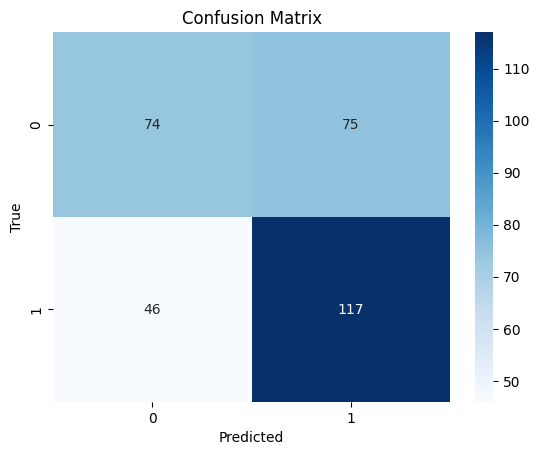

In [7]:
# Confusion Matrix
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')


In [8]:
# Additional Metrics
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, predictions))

Accuracy: 0.6121794871794872
              precision    recall  f1-score   support

           0       0.62      0.50      0.55       149
           1       0.61      0.72      0.66       163

    accuracy                           0.61       312
   macro avg       0.61      0.61      0.60       312
weighted avg       0.61      0.61      0.61       312



C:\Users\Admin\AppData\Local\Temp\ipykernel_39568\136011637.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


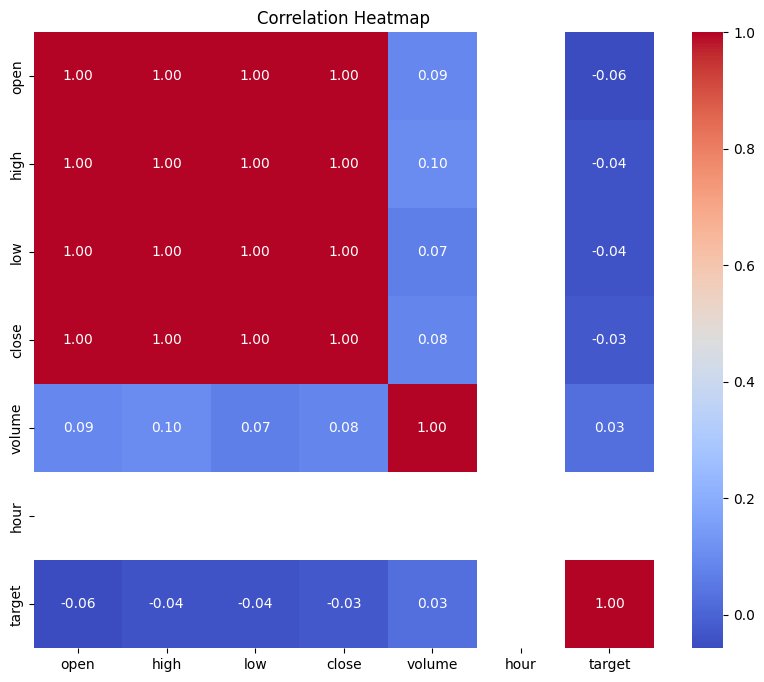

In [9]:
# Calculate correlation matrix
corr = df.corr()
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

In [10]:
# Values from the confusion matrix
true_negatives = 315  # Actual red days correctly predicted
false_positives = 589  # Green days incorrectly predicted as red
true_positives = 661  # Actual green days correctly predicted
false_negatives = 298  # Red days incorrectly predicted as green

# Calculating the actual number of red and green days
actual_red_days = true_negatives + false_positives
actual_green_days = true_positives + false_negatives
# so i do this to see how much acuraccy i would get just by random guesing , and it looks like that 52% is just random guessing
actual_red_days, actual_green_days

(904, 959)

In [11]:
#it also looks that the model have a tendency to predict more green days than red days

## more metrics 

In [12]:

def evaluate_model(classifier, X_test, y_test):
    """
    Evaluates the performance of a classifier, prints the precision, recall, F1 score,
    AUC-ROC, and plots the ROC curve and confusion matrix.
    
    Parameters:
    - classifier: The trained model to evaluate.
    - X_test: Test features.
    - y_test: True labels for the test data.
    """
    # Predict the class labels and the probabilities for the positive class
    y_pred = classifier.predict(X_test)
    y_pred_probs = classifier.predict_proba(X_test)[:, 1]

    # Calculate precision, recall, and F1 score
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calculate the AUC-ROC
    auc_roc = roc_auc_score(y_test, y_pred_probs)

    # Print the scores
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print(f'AUC-ROC: {auc_roc:.2f}')

    # Calculate and plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # Assign values from the confusion matrix to variables for clarity
    true_negatives, false_positives, false_negatives, true_positives = cm.ravel()
    
    # Print the interpretations
    print(f'True Negatives (Actual Red Days Correctly Predicted): {true_negatives}')
    print(f'False Positives (Green Days Incorrectly Predicted as Red): {false_positives}')
    print(f'True Positives (Actual Green Days Correctly Predicted): {true_positives}')
    print(f'False Negatives (Red Days Incorrectly Predicted as Green): {false_negatives}')


    # Plot the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_roc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    return precision, recall, f1, auc_roc

Precision: 0.61
Recall: 0.72
F1 Score: 0.66
AUC-ROC: 0.64
True Negatives (Actual Red Days Correctly Predicted): 74
False Positives (Green Days Incorrectly Predicted as Red): 75
True Positives (Actual Green Days Correctly Predicted): 117
False Negatives (Red Days Incorrectly Predicted as Green): 46


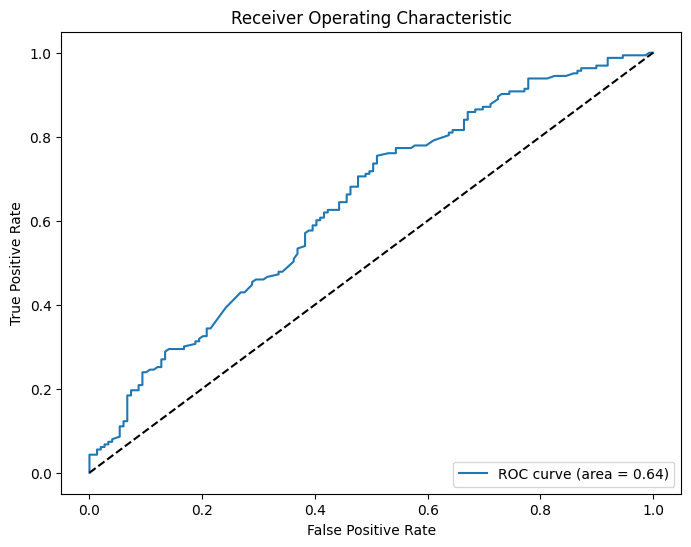

In [13]:
precision, recall, f1, auc_roc = evaluate_model(classifier, X_test, y_test)


In [14]:
#try get new features
# source https://www.augmento.ai/bitcoin-sentiment/
sentiment = pd.read_csv("augmento_btc.csv")

In [15]:
sentiment # so this looks very nice, but i should combine all the hours to have only daily data

,date,listing_close,twitter_hacks,twitter_pessimistic_doubtful,twitter_banks,twitter_selling,twitter_market_manipulation,twitter_de_centralisation,twitter_angry,twitter_etf,...,reddit_buying,reddit_warning,reddit_annoyed_frustrated,reddit_price,reddit_use_case_applications,reddit_rumor,reddit_scam_fraud,reddit_airdrop,reddit_optimistic,reddit_negative
0,2016-11-01 01:00:00,706.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,6.0,2.0,0.0,0.0,0.0,1.0,12.0
1,2016-11-01 02:00:00,709.99,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,2.0,0.0,0.0,4.0,2.0,0.0,0.0,0.0,1.0,8.0
2,2016-11-01 03:00:00,708.54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,2.0,7.0
3,2016-11-01 04:00:00,702.85,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,1.0,5.0
4,2016-11-01 05:00:00,708.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,5.0,3.0,0.0,0.0,0.0,1.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58081,2023-06-18 02:00:00,26474.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,9.0,0.0,2.0,0.0,0.0,5.0,18.0
58082,2023-06-18 03:00:00,26535.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,7.0,0.0,0.0,1.0,0.0,2.0,13.0
58083,2023-06-18 04:00:00,26528.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,4.0,0.0,0.0,7.0,4.0,2.0,0.0,0.0,3.0,15.0
58084,2023-06-18 05:00:00,26537.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,4.0,0.0,0.0,7.0,2.0,0.0,3.0,0.0,2.0,13.0


In [16]:
# Convert the 'date' column to datetime if it's not already
sentiment['date'] = pd.to_datetime(sentiment['date'])

In [17]:
# Set the 'date' column as the index
sentiment.set_index('date', inplace=True)
# Group by the date, ignoring the time part, and calculate the mean
daily_sentiment = sentiment.resample('D').mean()

In [18]:
# Reset the index so that 'date' is a column again
daily_sentiment.reset_index(inplace=True)

In [19]:
sentiment_filtered = daily_sentiment[daily_sentiment['date'] >= pd.to_datetime('2019-09-08')]
df_filtered = df[df['timestamp'] <= pd.to_datetime('2023-06-18')] #make them have both length

In [20]:
sentiment_filtered

,date,listing_close,twitter_hacks,twitter_pessimistic_doubtful,twitter_banks,twitter_selling,twitter_market_manipulation,twitter_de_centralisation,twitter_angry,twitter_etf,...,reddit_buying,reddit_warning,reddit_annoyed_frustrated,reddit_price,reddit_use_case_applications,reddit_rumor,reddit_scam_fraud,reddit_airdrop,reddit_optimistic,reddit_negative
1041,2019-09-08,10455.145000,0.041667,0.208333,0.916667,1.166667,0.041667,1.083333,0.166667,0.166667,...,2.583333,0.333333,0.208333,10.250000,5.041667,0.083333,1.541667,0.083333,3.791667,22.541667
1042,2019-09-09,10297.994583,0.375000,0.750000,1.041667,1.166667,0.416667,1.041667,0.500000,0.958333,...,3.125000,0.250000,0.083333,12.875000,5.625000,0.208333,1.416667,0.000000,3.958333,24.458333
1043,2019-09-10,10213.482917,0.333333,0.416667,1.791667,2.041667,0.500000,0.833333,0.375000,2.000000,...,3.250000,0.375000,0.291667,12.375000,6.333333,0.166667,1.833333,0.083333,4.458333,25.583333
1044,2019-09-11,10059.347500,0.083333,0.333333,1.458333,1.791667,0.375000,0.541667,0.166667,0.958333,...,3.250000,0.250000,0.166667,13.041667,5.458333,0.208333,1.125000,0.125000,4.041667,30.291667
1045,2019-09-12,10221.393750,0.541667,0.875000,2.458333,1.250000,0.250000,0.708333,0.583333,1.291667,...,3.833333,0.166667,0.000000,11.916667,4.916667,0.166667,1.500000,0.041667,3.958333,22.875000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2416,2023-06-14,25808.791667,0.041667,0.083333,0.166667,0.416667,0.000000,0.041667,0.125000,0.000000,...,1.791667,0.083333,0.000000,6.708333,3.000000,0.166667,0.791667,0.083333,2.708333,11.458333
2417,2023-06-15,25114.791667,0.000000,0.083333,0.166667,0.416667,0.000000,0.083333,0.083333,2.500000,...,2.416667,0.083333,0.041667,8.375000,2.791667,0.083333,1.416667,0.000000,2.333333,11.791667
2418,2023-06-16,25788.333333,0.000000,0.083333,0.083333,0.291667,0.083333,0.083333,0.000000,2.416667,...,2.416667,0.250000,0.000000,8.000000,2.583333,0.166667,0.916667,0.041667,2.708333,11.375000
2419,2023-06-17,26474.625000,0.000000,0.000000,0.000000,0.291667,0.000000,0.250000,0.041667,0.416667,...,1.625000,0.000000,0.041667,7.041667,2.000000,0.166667,0.750000,0.041667,2.166667,9.250000


In [21]:
df_filtered

,timestamp,open,high,low,close,volume,hour,target
0,2019-09-08,10000.00,10412.65,10000.00,10391.63,3096.291,0,1
1,2019-09-09,10316.62,10475.54,10077.22,10307.00,14824.373,0,0
2,2019-09-10,10307.00,10382.97,9940.87,10102.02,9068.955,0,0
3,2019-09-11,10094.27,10293.11,9884.31,10159.55,10897.922,0,1
4,2019-09-12,10163.06,10450.13,10042.12,10415.13,15609.634,0,1
...,...,...,...,...,...,...,...,...
1375,2023-06-14,25918.00,26099.30,24796.80,25115.90,464681.602,0,0
1376,2023-06-15,25115.90,25750.00,24777.00,25586.10,473971.375,0,1
1377,2023-06-16,25586.00,26526.90,25142.10,26336.00,533144.956,0,1
1378,2023-06-17,26335.90,26900.00,26170.80,26508.90,305738.396,0,0


In [22]:
df_filtered = df_filtered.rename(columns={'timestamp': 'date'}) # make both have a same column name


In [23]:
combined_df = pd.merge(df_filtered, sentiment_filtered, on='date', how='left')


In [24]:
nan_count = combined_df.isna().sum()
nan_count = nan_count[nan_count > 0]
print(nan_count)

Series([], dtype: int64)


In [25]:
combined_df # ok so we have a very extensive sentiment database together with our data,lets explore a bit the data and run the model again.

,date,open,high,low,close,volume,hour,target,listing_close,twitter_hacks,...,reddit_buying,reddit_warning,reddit_annoyed_frustrated,reddit_price,reddit_use_case_applications,reddit_rumor,reddit_scam_fraud,reddit_airdrop,reddit_optimistic,reddit_negative
0,2019-09-08,10000.00,10412.65,10000.00,10391.63,3096.291,0,1,10455.145000,0.041667,...,2.583333,0.333333,0.208333,10.250000,5.041667,0.083333,1.541667,0.083333,3.791667,22.541667
1,2019-09-09,10316.62,10475.54,10077.22,10307.00,14824.373,0,0,10297.994583,0.375000,...,3.125000,0.250000,0.083333,12.875000,5.625000,0.208333,1.416667,0.000000,3.958333,24.458333
2,2019-09-10,10307.00,10382.97,9940.87,10102.02,9068.955,0,0,10213.482917,0.333333,...,3.250000,0.375000,0.291667,12.375000,6.333333,0.166667,1.833333,0.083333,4.458333,25.583333
3,2019-09-11,10094.27,10293.11,9884.31,10159.55,10897.922,0,1,10059.347500,0.083333,...,3.250000,0.250000,0.166667,13.041667,5.458333,0.208333,1.125000,0.125000,4.041667,30.291667
4,2019-09-12,10163.06,10450.13,10042.12,10415.13,15609.634,0,1,10221.393750,0.541667,...,3.833333,0.166667,0.000000,11.916667,4.916667,0.166667,1.500000,0.041667,3.958333,22.875000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,2023-06-14,25918.00,26099.30,24796.80,25115.90,464681.602,0,0,25808.791667,0.041667,...,1.791667,0.083333,0.000000,6.708333,3.000000,0.166667,0.791667,0.083333,2.708333,11.458333
1376,2023-06-15,25115.90,25750.00,24777.00,25586.10,473971.375,0,1,25114.791667,0.000000,...,2.416667,0.083333,0.041667,8.375000,2.791667,0.083333,1.416667,0.000000,2.333333,11.791667
1377,2023-06-16,25586.00,26526.90,25142.10,26336.00,533144.956,0,1,25788.333333,0.000000,...,2.416667,0.250000,0.000000,8.000000,2.583333,0.166667,0.916667,0.041667,2.708333,11.375000
1378,2023-06-17,26335.90,26900.00,26170.80,26508.90,305738.396,0,0,26474.625000,0.000000,...,1.625000,0.000000,0.041667,7.041667,2.000000,0.166667,0.750000,0.041667,2.166667,9.250000


In [26]:
# Calculate correlation matrix
corr = combined_df.corr()

# Create a mask for correlations that are above 0.5 or below -0.5
mask = (corr > 0.5) | (corr < -0.5)
# Since the correlation of a variable with itself is always 1, we can remove those
# by setting the diagonal to False in the mask
np.fill_diagonal(mask.values, False)
# not too much succes

C:\Users\Admin\AppData\Local\Temp\ipykernel_39568\2501746361.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = combined_df.corr()


In [27]:
#i will just run the model to see what happens and then i will do some feature selection
X = combined_df.drop(["target","date"],axis=1) 
y = combined_df['target']



In [28]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the GBM classifier
classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
classifier.fit(X_train, y_train)

# Predict and evaluate the model
predictions = classifier.predict(X_test)

Precision: 0.69
Recall: 0.69
F1 Score: 0.69
AUC-ROC: 0.69
True Negatives (Actual Red Days Correctly Predicted): 76
False Positives (Green Days Incorrectly Predicted as Red): 47
True Positives (Actual Green Days Correctly Predicted): 105
False Negatives (Red Days Incorrectly Predicted as Green): 48


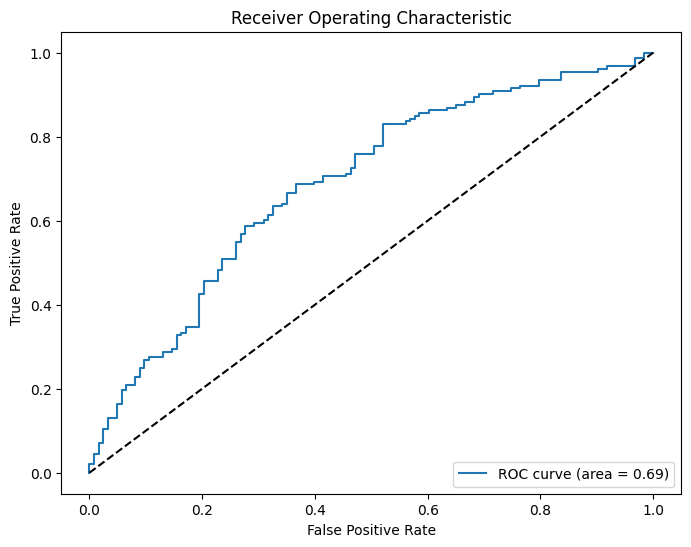

In [29]:
precision, recall, f1, auc_roc = evaluate_model(classifier, X_test, y_test)


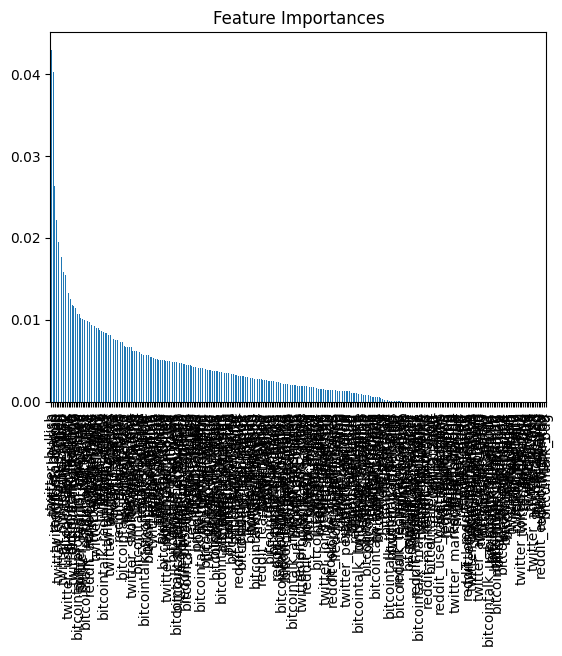

In [30]:
feature_importances = classifier.feature_importances_

# Create a pandas series with the feature importances
importances = pd.Series(feature_importances, index=X_train.columns)

# Sort the importances for better visualisation
sorted_importances = importances.sort_values(ascending=False)

# Plot the feature importances
import matplotlib.pyplot as plt

sorted_importances.plot(kind='bar')
plt.title('Feature Importances')
plt.show()

In [31]:
#lets try to run the model only with the features that are in the top 30% importance
threshold = sorted_importances.quantile(0.95)
top_features = sorted_importances[sorted_importances > threshold].index
filtered_X_train = combined_df[top_features]


In [32]:
filtered_X_train["open"] = df_filtered["open"]
filtered_X_train.dropna(inplace=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_39568\8301171.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_X_train["open"] = df_filtered["open"]
C:\Users\Admin\AppData\Local\Temp\ipykernel_39568\8301171.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_X_train.dropna(inplace=True)


In [111]:
pd.reset_option('display.max_rows')


In [34]:
filtered_X_train


,twitter_bullish,twitter_bearish,reddit_stablecoin,twitter_fomo_theme,twitter_euphoric_excited,open,reddit_bullish,twitter_pump_and_dump,bitcointalk_recovery,twitter_fork,twitter_use_case_applications,bitcointalk_learning,bitcointalk_adoption,twitter_investing_trading,twitter_dip
0,4.166667,2.916667,0.041667,0.166667,1.541667,10000.00,1.625000,0.0,0.291667,0.416667,3.125000,0.833333,4.916667,12.375000,0.208333
1,5.666667,3.333333,0.041667,0.208333,2.666667,10316.62,1.541667,0.0,0.125000,0.666667,3.958333,1.666667,5.875000,17.166667,0.291667
2,5.958333,3.041667,0.000000,0.166667,1.833333,10307.00,1.625000,0.0,0.166667,0.708333,3.083333,1.791667,6.583333,17.291667,0.833333
3,5.333333,4.625000,0.041667,0.041667,2.375000,10094.27,1.458333,0.0,0.125000,0.416667,2.833333,1.875000,7.625000,16.750000,0.958333
4,5.375000,2.875000,0.083333,0.083333,2.666667,10163.06,1.791667,0.0,0.250000,0.750000,3.250000,1.500000,6.125000,16.333333,0.416667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,1.583333,0.583333,0.041667,0.000000,0.416667,25918.00,0.833333,0.0,0.000000,0.000000,0.541667,3.166667,5.250000,3.166667,0.125000
1376,2.250000,0.833333,0.083333,0.000000,0.458333,25115.90,1.166667,0.0,0.083333,0.083333,0.208333,3.333333,5.875000,3.458333,0.250000
1377,1.875000,0.333333,0.000000,0.000000,0.583333,25586.00,1.541667,0.0,0.291667,0.125000,0.583333,3.083333,5.708333,3.375000,0.166667
1378,1.583333,0.250000,0.000000,0.000000,0.250000,26335.90,0.958333,0.0,0.041667,0.125000,0.625000,1.791667,4.416667,1.541667,0.000000


In [35]:

X = filtered_X_train
y = combined_df['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the GBM classifier on the scaled training data
classifier_filtered = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
classifier_filtered.fit(X_train, y_train)

# Predict and evaluate the model on the scaled test data
predictions = classifier_filtered.predict(X_test)


Precision: 0.69
Recall: 0.73
F1 Score: 0.71
AUC-ROC: 0.68
True Negatives (Actual Red Days Correctly Predicted): 74
False Positives (Green Days Incorrectly Predicted as Red): 49
True Positives (Actual Green Days Correctly Predicted): 111
False Negatives (Red Days Incorrectly Predicted as Green): 42


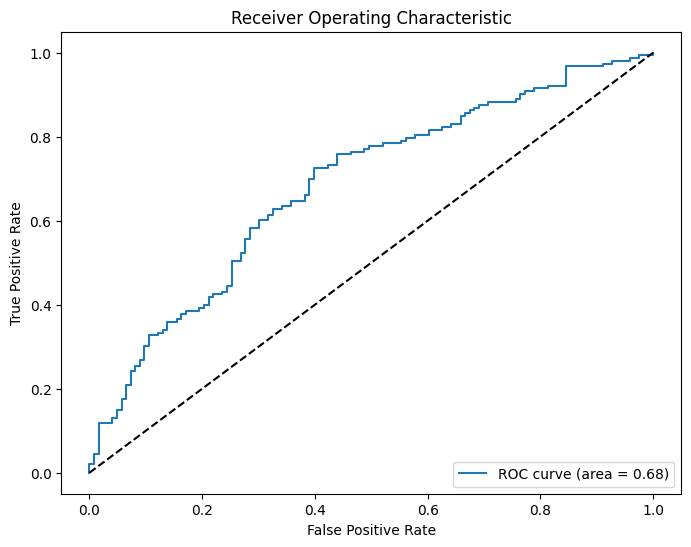

In [36]:
precision, recall, f1, auc_roc = evaluate_model(classifier_filtered, X_test, y_test)


## lets try with some log transofrmation in the open column then

In [37]:
filtered_X_train.loc[:, 'log_open'] = np.log(filtered_X_train['open'])

C:\Users\Admin\AppData\Local\Temp\ipykernel_39568\3090398575.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_X_train.loc[:, 'log_open'] = np.log(filtered_X_train['open'])


In [38]:
filtered_X_train=filtered_X_train.drop("open",axis=1)

In [39]:
#and rerun the model

In [40]:
#i will just run the model to see what happens and then i will do some feature selection
X = filtered_X_train
y = combined_df['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the GBM classifier on the scaled training data
# classifier_filtered = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
classifier_filtered = GradientBoostingClassifier(learning_rate= 0.1,max_depth= 3,min_samples_split=2, n_estimators=100,random_state=42)
classifier_filtered.fit(X_train, y_train)

# Predict and evaluate the model on the scaled test data
predictions = classifier_filtered.predict(X_test)


Precision: 0.69
Recall: 0.73
F1 Score: 0.71
AUC-ROC: 0.68
True Negatives (Actual Red Days Correctly Predicted): 74
False Positives (Green Days Incorrectly Predicted as Red): 49
True Positives (Actual Green Days Correctly Predicted): 111
False Negatives (Red Days Incorrectly Predicted as Green): 42


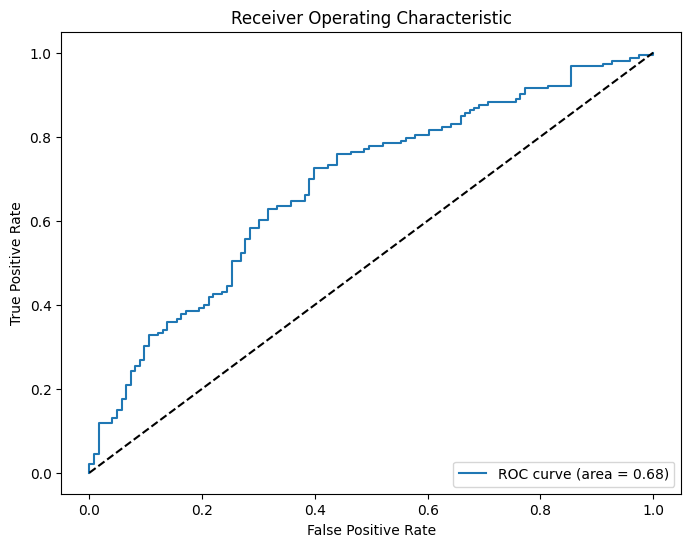

In [41]:
precision, recall, f1, auc_roc = evaluate_model(classifier_filtered, X_test, y_test)


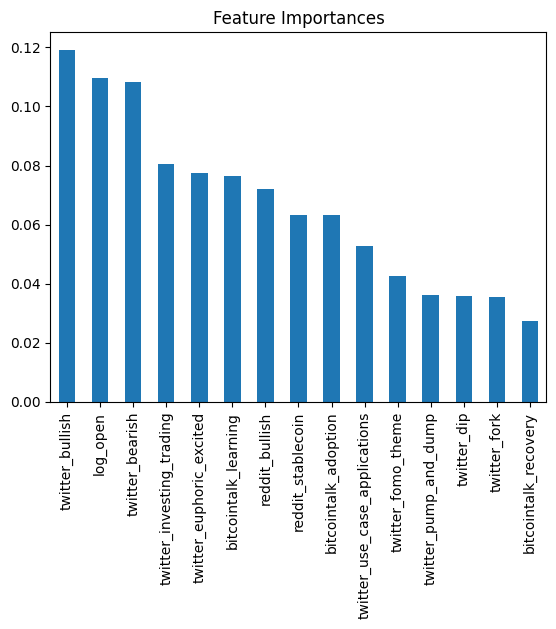

In [42]:
feature_importances = classifier_filtered.feature_importances_

# Create a pandas series with the feature importances
importances = pd.Series(feature_importances, index=X_train.columns)

# Sort the importances for better visualisation
sorted_importances = importances.sort_values(ascending=False)

# Plot the feature importances
import matplotlib.pyplot as plt

sorted_importances.plot(kind='bar')
plt.title('Feature Importances')
plt.show()

In [43]:
price_sentiment = filtered_X_train.copy()

In [44]:
price_sentiment

,twitter_bullish,twitter_bearish,reddit_stablecoin,twitter_fomo_theme,twitter_euphoric_excited,reddit_bullish,twitter_pump_and_dump,bitcointalk_recovery,twitter_fork,twitter_use_case_applications,bitcointalk_learning,bitcointalk_adoption,twitter_investing_trading,twitter_dip,log_open
0,4.166667,2.916667,0.041667,0.166667,1.541667,1.625000,0.0,0.291667,0.416667,3.125000,0.833333,4.916667,12.375000,0.208333,9.210340
1,5.666667,3.333333,0.041667,0.208333,2.666667,1.541667,0.0,0.125000,0.666667,3.958333,1.666667,5.875000,17.166667,0.291667,9.241511
2,5.958333,3.041667,0.000000,0.166667,1.833333,1.625000,0.0,0.166667,0.708333,3.083333,1.791667,6.583333,17.291667,0.833333,9.240579
3,5.333333,4.625000,0.041667,0.041667,2.375000,1.458333,0.0,0.125000,0.416667,2.833333,1.875000,7.625000,16.750000,0.958333,9.219723
4,5.375000,2.875000,0.083333,0.083333,2.666667,1.791667,0.0,0.250000,0.750000,3.250000,1.500000,6.125000,16.333333,0.416667,9.226515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,1.583333,0.583333,0.041667,0.000000,0.416667,0.833333,0.0,0.000000,0.000000,0.541667,3.166667,5.250000,3.166667,0.125000,10.162693
1376,2.250000,0.833333,0.083333,0.000000,0.458333,1.166667,0.0,0.083333,0.083333,0.208333,3.333333,5.875000,3.458333,0.250000,10.131256
1377,1.875000,0.333333,0.000000,0.000000,0.583333,1.541667,0.0,0.291667,0.125000,0.583333,3.083333,5.708333,3.375000,0.166667,10.149801
1378,1.583333,0.250000,0.000000,0.000000,0.250000,0.958333,0.0,0.041667,0.125000,0.625000,1.791667,4.416667,1.541667,0.000000,10.178688


In [45]:
price_sentiment["target"] = df["target"]

In [46]:
price_sentiment.to_csv("price_sentiment.csv",index=False)

## run model with indicators and sentiment features csv

In [47]:
indicators_sentiment=pd.read_csv("indicators_sentiment.csv")
indicators_sentiment

,high,low,close,volume,SMA_50,EMA_50,SMA_100,EMA_100,SMA_200,EMA_200,...,twitter_pump_and_dump,bitcointalk_recovery,twitter_fork,twitter_use_case_applications,bitcointalk_learning,bitcointalk_adoption,twitter_investing_trading,twitter_dip,log_open,target
0,6960.71,6436.26,6673.41,400684.542,8341.7136,7610.356378,8223.5975,8063.700802,8345.02810,8483.140417,...,0.041667,0.458333,0.416667,2.125000,0.875000,3.958333,15.666667,0.541667,8.815943,0.0
1,6777.50,6500.00,6733.76,281245.628,8283.7888,7575.980049,8224.7455,8037.365341,8326.73875,8465.733646,...,0.000000,0.416667,0.208333,2.458333,1.041667,4.208333,13.458333,0.583333,8.805910,0.0
2,6840.00,6230.00,6353.64,258213.519,8215.2992,7528.045145,8215.5075,8004.024245,8306.97195,8444.717789,...,0.000000,0.416667,0.250000,3.041667,1.125000,4.208333,15.875000,0.416667,8.814889,0.0
3,6354.74,6004.00,6230.95,341944.185,8143.4878,7477.178669,8206.3541,7968.913864,8287.61660,8422.690249,...,0.000000,0.416667,0.166667,1.791667,1.291667,4.375000,13.750000,0.291667,8.756783,0.0
4,6260.00,5857.60,5876.27,251335.919,8062.8846,7414.397937,8193.2729,7927.475372,8266.20020,8397.352734,...,0.041667,0.333333,0.125000,1.875000,0.791667,3.166667,12.666667,0.375000,8.737422,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,26099.30,24796.80,25115.90,464681.602,27326.3240,26928.685752,27259.1640,26441.066979,23665.38500,25270.304883,...,0.000000,0.000000,0.000000,0.541667,3.166667,5.250000,3.166667,0.125000,10.162693,0.0
1177,25750.00,24777.00,25586.10,473971.375,27270.1280,26876.035330,27293.1540,26424.136940,23711.20250,25273.447123,...,0.000000,0.083333,0.083333,0.208333,3.333333,5.875000,3.458333,0.250000,10.131256,1.0
1178,26526.90,25142.10,26336.00,533144.956,27207.6680,26854.857474,27339.5600,26422.391654,23761.86000,25284.019788,...,0.000000,0.291667,0.125000,0.583333,3.083333,5.708333,3.375000,0.166667,10.149801,1.0
1179,26900.00,26170.80,26508.90,305738.396,27151.8460,26841.290515,27401.1660,26424.104690,23812.23850,25296.207651,...,0.000000,0.041667,0.125000,0.625000,1.791667,4.416667,1.541667,0.000000,10.178688,0.0


Precision: 0.68
Recall: 0.74
F1 Score: 0.71
AUC-ROC: 0.70
True Negatives (Actual Red Days Correctly Predicted): 57
False Positives (Green Days Incorrectly Predicted as Red): 47
True Positives (Actual Green Days Correctly Predicted): 98
False Negatives (Red Days Incorrectly Predicted as Green): 35


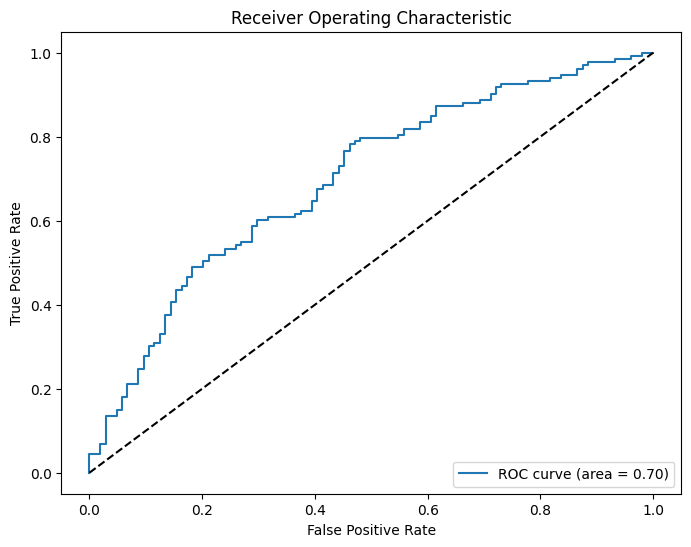

In [48]:
# rerun model with new df
X = indicators_sentiment.drop(["target"],axis=1) 
y = indicators_sentiment['target']
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the GBM classifier
classifier_indicators_sentiment = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
classifier_indicators_sentiment.fit(X_train, y_train)

# Predict and evaluate the model
predictions = classifier_indicators_sentiment.predict(X_test)


precision, recall, f1, auc_roc = evaluate_model(classifier_indicators_sentiment, X_test, y_test)


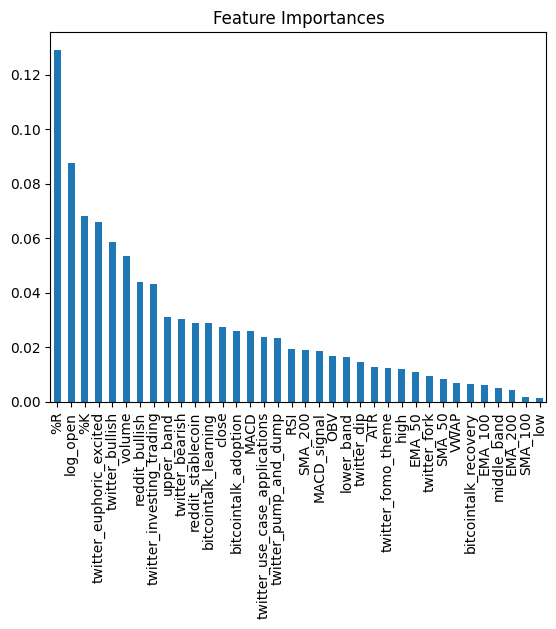

In [49]:
# lets see the feature importance
feature_importances = classifier_indicators_sentiment.feature_importances_

# Create a pandas series with the feature importances
importances = pd.Series(feature_importances, index=X_train.columns)

# Sort the importances for better visualisation
sorted_importances = importances.sort_values(ascending=False)

# Plot the feature importances
import matplotlib.pyplot as plt

sorted_importances.plot(kind='bar')
plt.title('Feature Importances')
plt.show()

# Now i want to try the model with only indicators,and then indicators and the rest of the data, after that i will do features selection


In [50]:
btc_indicators_seasonal = pd.read_csv("btc_indicators_seasonal.csv")

In [51]:
btc_indicators_seasonal=btc_indicators_seasonal.drop("timestamp",axis=1)

In [52]:
btc_indicators_seasonal["target"] = indicators_sentiment["target"]

In [53]:
btc_indicators_seasonal.dropna(inplace=True)

In [54]:
btc_indicators_seasonal

,open,high,low,close,volume,SMA_50,EMA_50,SMA_100,EMA_100,SMA_200,...,VWAP,OBV,%R,week_of_year,day_of_week,month_of_year,volume_7_days,volume_30_days,PVT,target
0,10000.00,10412.65,10000.00,10391.63,3096.291,8867.1508,10391.630000,8466.4587,10391.630000,8345.0281,...,10268.093333,0.000,-52.057069,36,6,9,93406.520,8.750668e+05,-120.730500,0.0
1,10316.62,10475.54,10077.22,10307.00,14824.373,8867.1508,10388.311176,8466.4587,10389.954158,8345.0281,...,10283.391431,-14824.373,-52.057069,37,0,9,93406.520,8.750668e+05,-120.730500,0.0
2,10307.00,10382.97,9940.87,10102.02,9068.955,8867.1508,10377.084072,8466.4587,10384.252492,8345.0281,...,10235.865909,-23893.328,-52.057069,37,1,9,93406.520,8.750668e+05,-301.088936,0.0
3,10094.27,10293.11,9884.31,10159.55,10897.922,8867.1508,10368.553324,8466.4587,10379.802938,8345.0281,...,10200.330286,-12995.406,-52.057069,37,2,9,93406.520,8.750668e+05,-239.026353,0.0
4,10163.06,10450.13,10042.12,10415.13,15609.634,8867.1508,10370.379860,8466.4587,10380.502483,8345.0281,...,10230.130130,2614.228,-52.057069,37,3,9,93406.520,8.750668e+05,153.659372,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,16449.20,16594.20,16396.00,16422.60,189370.345,18588.1760,18188.002591,19286.3170,19621.681306,21835.9825,...,28522.889419,-7964179.192,-43.867492,47,6,11,3016624.457,1.820814e+07,-507511.520422,0.0
1177,16422.50,16475.00,15984.10,16204.50,497137.869,18523.6660,18110.218176,19237.0840,19554.014349,21771.9015,...,28508.517055,-8461317.061,-54.792162,48,0,11,2723542.961,1.822307e+07,-514113.749620,1.0
1178,16204.60,16543.00,16088.00,16433.20,391410.854,18469.8500,18044.452757,19186.3600,19492.216045,21707.6960,...,28497.347608,-8069906.207,-36.708861,48,1,11,2535620.171,1.831909e+07,-508589.625932,1.0
1179,16433.30,17248.30,16421.50,17153.30,620324.950,18431.8160,18009.505590,19144.0230,19445.900876,21643.0635,...,28480.540469,-7449581.257,-5.262866,48,2,11,2609230.211,1.846061e+07,-481407.093224,0.0


Precision: 0.62
Recall: 0.64
F1 Score: 0.63
AUC-ROC: 0.59
True Negatives (Actual Red Days Correctly Predicted): 51
False Positives (Green Days Incorrectly Predicted as Red): 53
True Positives (Actual Green Days Correctly Predicted): 85
False Negatives (Red Days Incorrectly Predicted as Green): 48


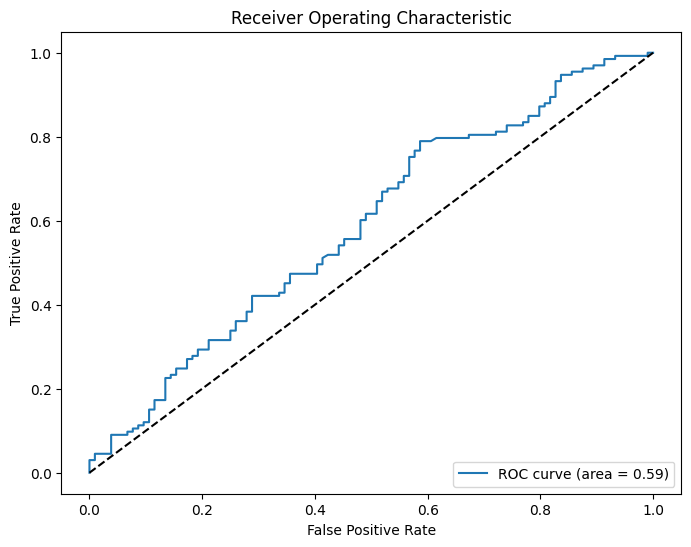

In [55]:
# rerun model with new df
X = btc_indicators_seasonal.drop(["target"],axis=1) 
y = btc_indicators_seasonal['target']
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the GBM classifier
classifier_indicators_seasonal = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
classifier_indicators_seasonal.fit(X_train, y_train)

# Predict and evaluate the model
predictions = classifier_indicators_seasonal.predict(X_test)


precision, recall, f1, auc_roc = evaluate_model(classifier_indicators_seasonal, X_test, y_test)

In [56]:
# # put together all dataframes
# price_sentiment = price_sentiment.drop(["target"],axis=1) 
# all_df = pd.concat([price_sentiment,btc_indicators_seasonal],axis=1)

In [57]:
# all_df.to_csv("all_together.csv",index = False)

In [64]:
# # run the model with this df
# X = all_df.drop("target",axis=1) 
# y = all_df['target']
# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Initialize and train the GBM classifier
# classifier_all_df = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
# classifier_all_df.fit(X_train, y_train)

# # Predict and evaluate the model
# predictions = classifier_all_df.predict(X_test)


# precision, recall, f1, auc_roc = evaluate_model(classifier_all_df, X_test, y_test)

In [66]:
# # now filter features by importance and do the last run of the model (hopefully)
# # lets see the feature importance
# feature_importances = classifier_all_df.feature_importances_

# # Create a pandas series with the feature importances
# importances = pd.Series(feature_importances, index=X_train.columns)

# # Sort the importances for better visualisation
# sorted_importances = importances.sort_values(ascending=False)

# # Plot the feature importances
# import matplotlib.pyplot as plt

# sorted_importances.plot(kind='bar')
# plt.title('Feature Importances')
# plt.show()

In [ ]:
# #lets try to run the model only with the features that are in the top 30% importance
# threshold = sorted_importances.quantile(0.20)
# top_features = sorted_importances[sorted_importances > threshold].index
# filtered_all_df= all_df[top_features]
# filtered_all_df

In [67]:
# # run the model with this df
# X = filtered_all_df
# y = all_df['target']
# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Initialize and train the GBM classifier
# classifier_filtered_all_df = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
# classifier_filtered_all_df.fit(X_train, y_train)

# # Predict and evaluate the model
# predictions = classifier_filtered_all_df.predict(X_test)


# precision, recall, f1, auc_roc = evaluate_model(classifier_filtered_all_df, X_test, y_test)

In [69]:
## lest go with trying different models 
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
# Assuming you have your dataset ready
defintive_model_df = pd.read_csv("price_sentiment.csv")
X = defintive_model_df.drop('target', axis=1)
y = defintive_model_df['target']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# List of model configurations
models = [
    {'model': GradientBoostingClassifier(), 'name': 'GradientBoostingClassifier'},
    {'model': RandomForestClassifier(), 'name': 'RandomForestClassifier'},
    {'model': AdaBoostClassifier(), 'name': 'AdaBoostClassifier'},
    {'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss'), 'name': 'XGBClassifier'},
    {'model': LGBMClassifier(), 'name': 'LGBMClassifier'},
    {'model': CatBoostClassifier(verbose=0), 'name': 'CatBoostClassifier'},
    {'model': LogisticRegression(), 'name': 'LogisticRegression'},
    {'model': SVC(), 'name': 'SVC'},
    {'model': KNeighborsClassifier(), 'name': 'KNeighborsClassifier'},
    {'model': GaussianNB(), 'name': 'GaussianNB'},
    {'model': DecisionTreeClassifier(), 'name': 'DecisionTreeClassifier'},
    {'model': SGDClassifier(), 'name': 'SGDClassifier'},
    {'model': RidgeClassifier(), 'name': 'RidgeClassifier'},
    {'model': ExtraTreesClassifier(), 'name': 'ExtraTreesClassifier'},
    {'model': QuadraticDiscriminantAnalysis(), 'name': 'QuadraticDiscriminantAnalysis'},
    {'model': MLPClassifier(max_iter=1000), 'name': 'MLPClassifier'},
    {'model': BaggingClassifier(), 'name': 'BaggingClassifier'}
]

# Running and evaluating each model
for config in models:
    model = config['model']
    model_name = config['name']
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, predictions)
    print(f"{model_name}: Test Accuracy = {accuracy}")

GradientBoostingClassifier: Test Accuracy = 0.6702898550724637
RandomForestClassifier: Test Accuracy = 0.6557971014492754
AdaBoostClassifier: Test Accuracy = 0.6268115942028986
XGBClassifier: Test Accuracy = 0.6340579710144928
[LightGBM] [Info] Number of positive: 579, number of negative: 525
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1598
[LightGBM] [Info] Number of data points in the train set: 1104, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.524457 -> initscore=0.097904
[LightGBM] [Info] Start training from score 0.097904
LGBMClassifier: Test Accuracy = 0.6123188405797102
CatBoostClassifier: Test Accuracy = 0.6630434782608695
LogisticRegression: Test Accuracy = 0.6195652173913043
SVC: Test Accuracy = 0.6159420289855072
KNeighborsClassifier: Test Accuracy = 0.5652173913043478
GaussianNB: Test Accuracy = 

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [70]:

# Assuming you have your dataset ready
X = defintive_model_df.drop('target', axis=1)
y = defintive_model_df['target']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the data (if necessary, depending on your data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Setting up the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300,600],
    'learning_rate': [0.01, 0.1, 0.2,0.001],
    'max_depth': [3, 4, 5,10],
    'min_samples_split': [2, 4, 6,12]
}

# Create a base model
gb = GradientBoostingClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train)

# Getting the best parameters
best_params = grid_search.best_params_

# Train the model using the best parameters
best_gb = GradientBoostingClassifier(**best_params)
best_gb.fit(X_train_scaled, y_train)

# Predicting and evaluating
predictions = best_gb.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)

print("Best Hyperparameters:", best_params)
print("Test Accuracy:", accuracy)


Fitting 3 folds for each of 256 candidates, totalling 768 fits
Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_split': 6, 'n_estimators': 100}
Test Accuracy: 0.6304347826086957


# RESULTS 

## Original binance data (ohcl ,vol,target)
+ Precision: 0.61
+ Recall: 0.70
+ F1 Score: 0.65
+ AUC-ROC: 0.64
+ True Negatives (Actual Red Days Correctly Predicted): 74
+ False Positives (Green Days Incorrectly Predicted as Red): 74
+ True Positives (Actual Green Days Correctly Predicted): 115
+ False Negatives (Red Days Incorrectly Predicted as Green): 49
+ overall score 63

## Original data + sentiment data (288 cols)
+ Precision: 0.69
+ Recall: 0.69
+ F1 Score: 0.69
+ AUC-ROC: 0.69
+ True Negatives (Actual Red Days Correctly Predicted): 76
+ False Positives (Green Days Incorrectly Predicted as Red): 47
+ True Positives (Actual Green Days Correctly Predicted): 105
+ False Negatives (Red Days Incorrectly Predicted as Green): 48
+ overall score  69

## Original data + sentiment but cols filtered by importance
+ Precision: 0.69
+ Recall: 0.73
+ F1 Score: 0.71
+ AUC-ROC: 0.68
+ True Negatives (Actual Red Days Correctly Predicted): 74
+ False Positives (Green Days Incorrectly Predicted as Red): 49
+ True Positives (Actual Green Days Correctly Predicted): 111
+ False Negatives (Red Days Incorrectly Predicted as Green): 42
+ overall score 69.3

## Original data + sentiment filetered + indicators
+ Precision: 0.66
+ Recall: 0.60
+ F1 Score: 0.63
+ AUC-ROC: 0.67
+ True Negatives (Actual Red Days Correctly Predicted): 76
+ False Positives (Green Days Incorrectly Predicted as Red): 47
+ True Positives (Actual Green Days Correctly Predicted): 92
+ False Negatives (Red Days Incorrectly Predicted as Green): 61
+ overall score 65.3


## Only indicators df with seasonal features
+ Precision: 0.68
+ Recall: 0.59
+ F1 Score: 0.63
+ AUC-ROC: 0.66
+ True Negatives (Actual Red Days Correctly Predicted): 81
+ False Positives (Green Days Incorrectly Predicted as Red): 42
+ True Positives (Actual Green Days Correctly Predicted): 90
+ False Negatives (Red Days Incorrectly Predicted as Green): 63
+ overall score 65.6

## Indicators and sentiment alltogether with seasonal features

+ Precision: 0.66
+ Recall: 0.58
+ F1 Score: 0.62
+ AUC-ROC: 0.67
+ True Negatives (Actual Red Days Correctly Predicted): 77
+ False Positives (Green Days Incorrectly Predicted as Red): 46
+ True Positives (Actual Green Days Correctly Predicted): 89
+ False Negatives (Red Days Incorrectly Predicted as Green): 64
+ overall score 65

## Indicators and sentiment alltogether with seasonal features but filtered by importance
+ Precision: 0.65
+ Recall: 0.58
+ F1 Score: 0.61
+ AUC-ROC: 0.66
+ True Negatives (Actual Red Days Correctly Predicted): 75
+ False Positives (Green Days Incorrectly Predicted as Red): 48
+ True Positives (Actual Green Days Correctly Predicted): 88
+ False Negatives (Red Days Incorrectly Predicted as Green): 65
+ overall score 64

# Conclusion 
## So we have a winner, 
### Original data + sentiment but cols filtered by importance
+ Precision: 0.69
+ Recall: 0.73
+ F1 Score: 0.71
+ AUC-ROC: 0.68
+ True Negatives (Actual Red Days Correctly Predicted): 74
+ False Positives (Green Days Incorrectly Predicted as Red): 49
+ True Positives (Actual Green Days Correctly Predicted): 111
+ False Negatives (Red Days Incorrectly Predicted as Green): 42
+ overall score 69.3

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


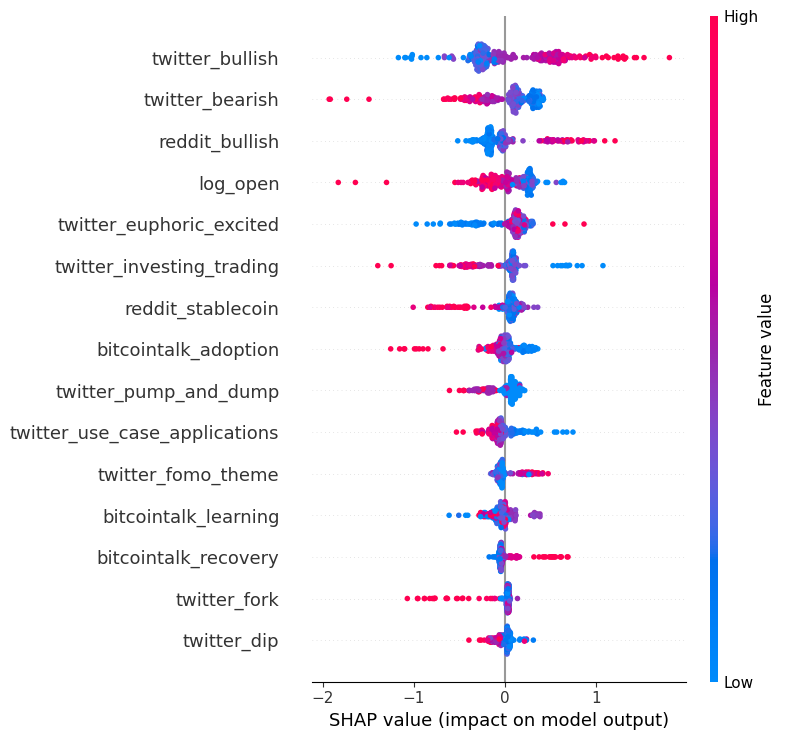

In [71]:
import shap
# Assuming your dataset is ready
X = filtered_X_train
y = combined_df['target']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train your Gradient Boosting Classifier
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

test_predictions = model.predict(X_test)
all_predictions = model.predict(X)

# Create the SHAP Explainer
explainer = shap.Explainer(model, X_train)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

# Visualizing the first prediction's explanation
shap.initjs()  # Required for visualizations in Jupyter notebooks
shap.summary_plot(shap_values, X_test)



In [72]:
filtered_X_train['predictions'] = all_predictions

In [73]:
filtered_X_train["target"] = combined_df["target"]
filtered_X_train["close"] = combined_df["close"]


In [81]:
filtered_X_train["open"] = combined_df["open"]


In [82]:
filtered_X_train.to_csv("final_data.csv",index=False)

In [137]:
final_data=pd.read_csv("final_data.csv")


In [138]:
final_data['price_change_percentage'] = ((final_data['close'].shift(-1) - final_data['open']) / final_data['open']) * 100


In [139]:
final_data

,twitter_bullish,twitter_bearish,reddit_stablecoin,twitter_fomo_theme,twitter_euphoric_excited,reddit_bullish,twitter_pump_and_dump,bitcointalk_recovery,twitter_fork,twitter_use_case_applications,bitcointalk_learning,bitcointalk_adoption,twitter_investing_trading,twitter_dip,log_open,predictions,target,close,open,price_change_percentage
0,4.166667,2.916667,0.041667,0.166667,1.541667,1.625000,0.0,0.291667,0.416667,3.125000,0.833333,4.916667,12.375000,0.208333,9.210340,0,1,10391.63,10000.00,3.070000
1,5.666667,3.333333,0.041667,0.208333,2.666667,1.541667,0.0,0.125000,0.666667,3.958333,1.666667,5.875000,17.166667,0.291667,9.241511,0,0,10307.00,10316.62,-2.080139
2,5.958333,3.041667,0.000000,0.166667,1.833333,1.625000,0.0,0.166667,0.708333,3.083333,1.791667,6.583333,17.291667,0.833333,9.240579,0,0,10102.02,10307.00,-1.430581
3,5.333333,4.625000,0.041667,0.041667,2.375000,1.458333,0.0,0.125000,0.416667,2.833333,1.875000,7.625000,16.750000,0.958333,9.219723,0,1,10159.55,10094.27,3.178635
4,5.375000,2.875000,0.083333,0.083333,2.666667,1.791667,0.0,0.250000,0.750000,3.250000,1.500000,6.125000,16.333333,0.416667,9.226515,0,1,10415.13,10163.06,1.754196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,1.583333,0.583333,0.041667,0.000000,0.416667,0.833333,0.0,0.000000,0.000000,0.541667,3.166667,5.250000,3.166667,0.125000,10.162693,0,0,25115.90,25918.00,-1.280577
1376,2.250000,0.833333,0.083333,0.000000,0.458333,1.166667,0.0,0.083333,0.083333,0.208333,3.333333,5.875000,3.458333,0.250000,10.131256,1,1,25586.10,25115.90,4.857879
1377,1.875000,0.333333,0.000000,0.000000,0.583333,1.541667,0.0,0.291667,0.125000,0.583333,3.083333,5.708333,3.375000,0.166667,10.149801,1,1,26336.00,25586.00,3.607051
1378,1.583333,0.250000,0.000000,0.000000,0.250000,0.958333,0.0,0.041667,0.125000,0.625000,1.791667,4.416667,1.541667,0.000000,10.178688,0,0,26508.90,26335.90,-0.023542


In [140]:
def simulate_betting_strategy_corrected_v3(df, bet_amount):
    """
    Further corrected simulation of the betting strategy.

    Args:
    df (DataFrame): Dataframe containing the data.
    bet_amount (float): Amount to bet each day.

    Returns:
    DataFrame: Updated dataframe with bet outcomes and total result.
    """

    # Function to calculate bet outcome
    def calculate_bet_outcome(row):
        # Calculate profit or loss based on prediction accuracy and price change
        profit_or_loss = bet_amount * abs(row['price_change_percentage'] / 100)
        if row['predictions'] == row['target']:
            return profit_or_loss
        else:
            return -profit_or_loss

    # Apply the function to calculate bet outcomes
    df['bet_outcome'] = df.apply(calculate_bet_outcome, axis=1)

    # Calculate cumulative results
    df['total_result'] = df['bet_outcome'].cumsum()

    return df

In [141]:
df_betting= simulate_betting_strategy_corrected_v3(final_data, bet_amount)


In [142]:
#pd.set_option('display.max_rows', None)
pd.reset_option('display.max_rows')

In [143]:
df_betting

,twitter_bullish,twitter_bearish,reddit_stablecoin,twitter_fomo_theme,twitter_euphoric_excited,reddit_bullish,twitter_pump_and_dump,bitcointalk_recovery,twitter_fork,twitter_use_case_applications,...,twitter_investing_trading,twitter_dip,log_open,predictions,target,close,open,price_change_percentage,bet_outcome,total_result
0,4.166667,2.916667,0.041667,0.166667,1.541667,1.625000,0.0,0.291667,0.416667,3.125000,...,12.375000,0.208333,9.210340,0,1,10391.63,10000.00,3.070000,-3.070000,-3.070000
1,5.666667,3.333333,0.041667,0.208333,2.666667,1.541667,0.0,0.125000,0.666667,3.958333,...,17.166667,0.291667,9.241511,0,0,10307.00,10316.62,-2.080139,2.080139,-0.989861
2,5.958333,3.041667,0.000000,0.166667,1.833333,1.625000,0.0,0.166667,0.708333,3.083333,...,17.291667,0.833333,9.240579,0,0,10102.02,10307.00,-1.430581,1.430581,0.440720
3,5.333333,4.625000,0.041667,0.041667,2.375000,1.458333,0.0,0.125000,0.416667,2.833333,...,16.750000,0.958333,9.219723,0,1,10159.55,10094.27,3.178635,-3.178635,-2.737915
4,5.375000,2.875000,0.083333,0.083333,2.666667,1.791667,0.0,0.250000,0.750000,3.250000,...,16.333333,0.416667,9.226515,0,1,10415.13,10163.06,1.754196,-1.754196,-4.492111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,1.583333,0.583333,0.041667,0.000000,0.416667,0.833333,0.0,0.000000,0.000000,0.541667,...,3.166667,0.125000,10.162693,0,0,25115.90,25918.00,-1.280577,1.280577,3620.343936
1376,2.250000,0.833333,0.083333,0.000000,0.458333,1.166667,0.0,0.083333,0.083333,0.208333,...,3.458333,0.250000,10.131256,1,1,25586.10,25115.90,4.857879,4.857879,3625.201815
1377,1.875000,0.333333,0.000000,0.000000,0.583333,1.541667,0.0,0.291667,0.125000,0.583333,...,3.375000,0.166667,10.149801,1,1,26336.00,25586.00,3.607051,3.607051,3628.808865
1378,1.583333,0.250000,0.000000,0.000000,0.250000,0.958333,0.0,0.041667,0.125000,0.625000,...,1.541667,0.000000,10.178688,0,0,26508.90,26335.90,-0.023542,0.023542,3628.832407


In [144]:
def calculate_win_rate(df):
    """
    Calculate and add a column for the win rate in the betting strategy.

    Args:
    df (DataFrame): Dataframe containing the data.

    Returns:
    DataFrame: Updated dataframe with win rate column.
    """
    # Calculate whether each bet is a win (1) or a loss (0)
    df['bet_win'] = (df['predictions'] == df['target']).astype(int)

    # Calculate cumulative wins and number of bets
    df['cumulative_wins'] = df['bet_win'].cumsum()
    df['total_bets'] = range(1, len(df) + 1)

    # Calculate win rate
    df['win_rate'] = df['cumulative_wins'] / df['total_bets']

    return df

In [145]:
df_with_win_rate = calculate_win_rate(df_betting)



In [155]:
df_with_win_rate.to_csv("final_data_results.csv", index=False)

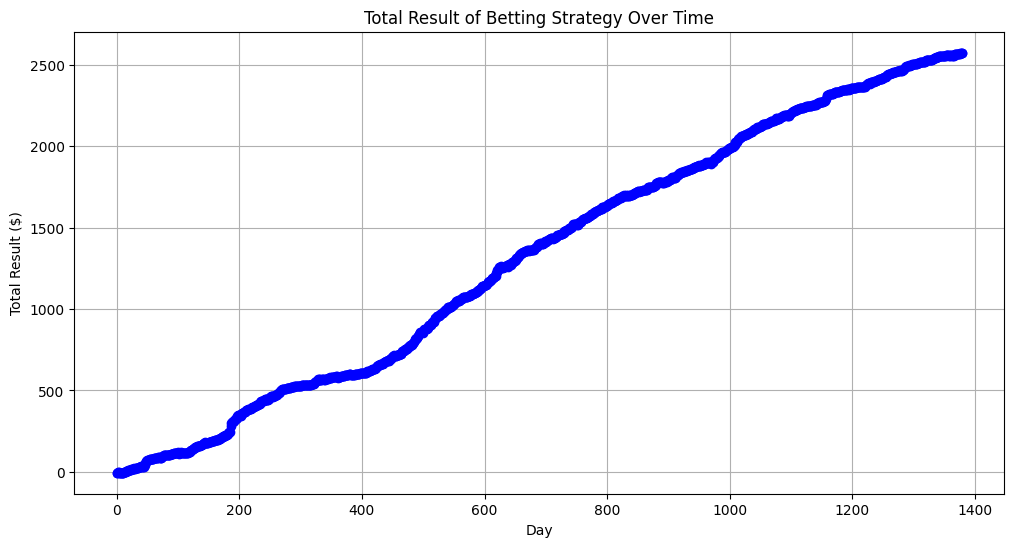

In [136]:
# Plotting the total result over time
plt.figure(figsize=(12, 6))
plt.plot(df_with_win_rate['total_result'], color='blue', marker='o')
plt.title('Total Result of Betting Strategy Over Time')
plt.xlabel('Day')
plt.ylabel('Total Result ($)')
plt.grid(True)
plt.show()

In [151]:
def calculate_consecutive_stats(series):
    """
    Calculate the maximum number of consecutive occurrences in a binary series.

    Args:
    series (pd.Series): Series of binary values (0 and 1) representing wins and losses.

    Returns:
    int: Maximum number of consecutive occurrences.
    """
    # Create a group identifier for consecutive sequences
    group = (series != series.shift()).cumsum()
    # Count the length of each group and find the maximum
    return series.groupby(group).sum().max()



def calculate_betting_statistics(df):
    """
    Calculate and print out betting statistics.

    Args:
    df (DataFrame): Dataframe containing the betting results.

    Returns:
    None: Prints out the betting statistics.
    """
    # Biggest win and biggest loss
    biggest_win = df['bet_outcome'].max()
    biggest_loss = df['bet_outcome'].min()

    # Maximum consecutive wins and losses
    max_wins_in_a_row = calculate_consecutive_stats(df['bet_win'])
    max_losses_in_a_row = calculate_consecutive_stats(1 - df['bet_win'])

    # Final total amount
    final_total_amount = df['total_result'].iloc[-2]

    # Printing out the results
    print(f"Biggest win: ${biggest_win:.2f}")
    print(f"Biggest loss: ${biggest_loss:.2f}")
    print(f"Maximum wins in a row: {max_wins_in_a_row}")
    print(f"Maximum losses in a row: {max_losses_in_a_row}")
    print(f"Final total amount: ${final_total_amount:.2f}")

In [152]:
calculate_betting_statistics(df_with_win_rate)

Biggest win: $39.67
Biggest loss: $-17.96
Maximum wins in a row: 40
Maximum losses in a row: 5
Final total amount: $3628.83


In [154]:
# Commission of 0.20% for each trade closure
commission = 0.002

# Random Betting Strategy (Coin Flip)
np.random.seed(0)  # for reproducibility
coin_flips = np.random.choice([1, -1], size=len(final_data))  # 1 for long, -1 for short
daily_returns = (final_data['close'] - final_data['open']) / final_data['open']
coin_flip_outcome = (daily_returns - commission) * coin_flips
coin_flip_total_return = coin_flip_outcome.sum()

# Buy and Hold Strategy
buy_and_hold_return = ((final_data['close'].iloc[-1] - final_data['open'].iloc[0]) / final_data['open'].iloc[0]) - commission

# Dollar-Cost Averaging (DCA) Strategy
investment_per_period = 100  # assuming $100 investment at each period
total_investment = investment_per_period * len(final_data)
total_value = (investment_per_period / final_data['open']).sum() * final_data['close'].iloc[-1] - (commission * len(final_data))
dca_return = (total_value - total_investment) / total_investment

buy_and_hold_return, dca_return, coin_flip_total_return

(1.63097, 0.5356630481645173, 3.063198423365587)

In [156]:
final_data_results=pd.read_csv("final_data_results.csv")

In [159]:
final_data_results["date"] = df["timestamp"]

In [160]:
final_data_results

,twitter_bullish,twitter_bearish,reddit_stablecoin,twitter_fomo_theme,twitter_euphoric_excited,reddit_bullish,twitter_pump_and_dump,bitcointalk_recovery,twitter_fork,twitter_use_case_applications,...,close,open,price_change_percentage,bet_outcome,total_result,bet_win,cumulative_wins,total_bets,win_rate,date
0,4.166667,2.916667,0.041667,0.166667,1.541667,1.625000,0.0,0.291667,0.416667,3.125000,...,10391.63,10000.00,3.070000,-3.070000,-3.070000,0,0,1,0.000000,2019-09-08
1,5.666667,3.333333,0.041667,0.208333,2.666667,1.541667,0.0,0.125000,0.666667,3.958333,...,10307.00,10316.62,-2.080139,2.080139,-0.989861,1,1,2,0.500000,2019-09-09
2,5.958333,3.041667,0.000000,0.166667,1.833333,1.625000,0.0,0.166667,0.708333,3.083333,...,10102.02,10307.00,-1.430581,1.430581,0.440720,1,2,3,0.666667,2019-09-10
3,5.333333,4.625000,0.041667,0.041667,2.375000,1.458333,0.0,0.125000,0.416667,2.833333,...,10159.55,10094.27,3.178635,-3.178635,-2.737915,0,2,4,0.500000,2019-09-11
4,5.375000,2.875000,0.083333,0.083333,2.666667,1.791667,0.0,0.250000,0.750000,3.250000,...,10415.13,10163.06,1.754196,-1.754196,-4.492111,0,2,5,0.400000,2019-09-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,1.583333,0.583333,0.041667,0.000000,0.416667,0.833333,0.0,0.000000,0.000000,0.541667,...,25115.90,25918.00,-1.280577,1.280577,3620.343936,1,1135,1376,0.824855,2023-06-14
1376,2.250000,0.833333,0.083333,0.000000,0.458333,1.166667,0.0,0.083333,0.083333,0.208333,...,25586.10,25115.90,4.857879,4.857879,3625.201815,1,1136,1377,0.824982,2023-06-15
1377,1.875000,0.333333,0.000000,0.000000,0.583333,1.541667,0.0,0.291667,0.125000,0.583333,...,26336.00,25586.00,3.607051,3.607051,3628.808865,1,1137,1378,0.825109,2023-06-16
1378,1.583333,0.250000,0.000000,0.000000,0.250000,0.958333,0.0,0.041667,0.125000,0.625000,...,26508.90,26335.90,-0.023542,0.023542,3628.832407,1,1138,1379,0.825236,2023-06-17


In [161]:
# Function to write trade results to a text file
def write_trades_to_file_with_date_check(df, file_path, include_date):
    with open(file_path, 'w') as file:
        for index, row in df.iterrows():
            # Determine if the trade was a buy (long) or sell (short)
            trade_type = "long" if row['predictions'] == 1 else "short"
            # Include date in the trade information if the column exists
            trade_info = f"Trade {index + 1}"
            if include_date:
                trade_info += f" (Date: {row['date']})"
            trade_info += f": {trade_type} at the price of {row['open']} and closed at the price of {row['close']} with the result of {row['bet_outcome']}\n"
            # Write to file
            file.write(trade_info)

# Specify the path for the new text file
output_file_path = 'trade_results.txt'

# Write the trade results to the file
write_trades_to_file(final_data_results, output_file_path)

output_file_path

'trade_results.txt'